# Emergency Response 
Marcela Radilla Deloya 

CS166 

Spring 2020

### Model description 

The situation being modeled attempts to represent the emergency response of the London Ambulance Service. The model aims to compare two different strategies of allocating ambulances in the city using a single ambulance dispatch method. It consists of a network where each node represents a different neighborhood in the city of London. Each neighborhood has a different rate at which it generates a request for an ambulance (example: crime rate, traffic accident rate, house accident rate, etc). 


When an ambulance request is generated, the ambulance is selected to attend the call using the dispatch method of the model. This ambulance will move from its station to the specific neighborhood, attend the patient, and go back to its station. The ambulance must return to its station before it can become available to attend another call. 


The time it takes for an ambulace to attend a call will not be the same amount of time it will remain unavailable since it has to return to the station. Before returning to the station, it must go to the specific neighborhood, reach the specific location of the request, attend the patient, and go back to the station. The time to reach the specific location and attend the patient will be given by a random number between 0 and 8 minutes.


With each strategy, I will calculate the frequencies of the average time taken to assist an emergency after an ambulance is requested.  I will also measure the amount of times that the most active ambulance was called, and the frequencies in number of ambulances that were not called once during a particular day.

### Model implementation

In [1]:
import networkx as nx
import random as random
import numpy as np
from statistics import mean
import matplotlib.pyplot as plt
from scipy.stats import sem, t
from scipy import mean

In [2]:
class EmergencyResponse():
    '''
    This is a simulation of ambulance response to different neighborhoods in London
    
    network: the graph of the city 
    em_probs: given for each of the 16 neighborhoods, the probability 
    of generating an ambulance request in a given time. 
                            
    total: total number of ambulances in the city. Number of ambulances 
    will be equal between stations
    
    stations: list of nodes that represent the neighborhoods with an ambulance station
    '''
    def __init__(self,network,em_probs,total,stations):
        
        self.network=network
        self.total=total
        self.stations=stations
        self.em_probs=em_probs
        #list for nonavailable ambulances (empty at first)
        self.ambulance_list=[] 
        #creating a list for all available ambulances
        self.yes_amb=[] 
        #all stations have the same number of ambulances 
        self.per_station=int(self.total/len(self.stations))
        
        self.stations_list=[]
        #creating stations
        for t in range(len(self.stations)):
            self.stations_list.append(Station(self.stations[t]))
            for i in range(self.per_station):
                new_amb=Ambulance(self.stations[t])
                self.stations_list[t].available.append(new_amb)
                self.ambulance_list.append(new_amb)
        self.idle_list=[]
        #initializing steps at 0 
        self.steps=0
        #creating an empty patient list, this list will house requests from 
        #Patient objects that have been generated and are currently waiting for an ambulance 
        self.patient_list=[]
        #this is an empty list to append the waiting times of all the generated requests 
        self.times_list=[]
        #the total amount of emergencies attended during the simulation
        self.emergencies_attended=0

    def create_paths(self): #
        '''
        this function creates an array with the shortest path lengths between the stations
        and all nodes of the network. we will access these paths later to determine the 
        closest station to a node and the path length to update the time ambulances will be 
        assisting an emergency
        '''
        self.paths=np.zeros((16,int(len(self.stations))))
        for s in range(len(self.stations)):
            dictionary=nx.single_source_dijkstra_path_length(G,s)
            for b in self.network.nodes:
                self.paths[b][s]=dictionary[b]
        #print('paths for node 1:',self.paths[1])
        #print('shortest is:',min(self.paths[1]))
        #print('index of shortest is',np.argmin(self.paths[1]))

    
    def assign(self):
        '''
        This function looks at the update list and assigns as many ambulances as possibe
        It also removes people from the patient_list 
    
        '''
        #go through the request list 
        for p in self.patient_list:
            #getting the index for the closest station
            closest_len=min(self.paths[p.origin])
            closest_ind=np.argmin(self.paths[p.origin])
            #checking if the closest station has ambulances available 
            if len(self.stations_list[closest_ind].available)>0:
                #If there is an ambulance at their closest station, assign it
                assigned=self.stations_list[closest_ind].available[-1]
                assigned.state=False
                #set their trackers to determine the time they are going to be unavailable
                #the tracker time becomes 2*the path length to account for the trip back to 
                #the station, plus a random number from 0 to 8 that represents the time 
                #in minutes that it might take for the ambulance to reach the person
                self.extra=int(np.random.uniform(0,8))
                assigned.tracker=2*(int(closest_len))+self.extra
                assigned.counter+=1
                #update unavailable ambulance lists with recently assigned ambulances 
                self.stations_list[closest_ind].available.remove(assigned)
                self.stations_list[closest_ind].not_available.append(assigned)
                p.total_time+=closest_len+self.extra
                #print('patient assigned, total time is:',p.total_time)
                self.times_list.append(p.total_time)
                self.patient_list.remove(p)
                #adding 1 to the total number of emergencies attended 
                self.emergencies_attended+=1
        #print(sim.times_list)
        
    def update(self):
        #generate requests if it's time: 
        if self.steps%10==0 or self.steps==0:
            for i in range(16):
                if np.random.random()<self.em_probs[i]:
                    self.patient_list.append(Patient(i))
        for p in self.patient_list:
            p.total_time+=1
            #print('Patient list:',self.patient_list)
        #for all unavailable ambulances, do -1 on their tracker for the minute passed 
        #update those newly available ambulances when their tracker hits 0
        for s in self.stations_list:
            for a in s.not_available:
                if a.state==False: 
                    a.tracker-=1
                    if a.tracker==0:
                        s.available.append(a)
                        s.not_available.remove(a)
                        a.state=True
        #check request list and assign as many ambulances as possible 
        #and update availability lists accordingly 
        self.assign()
        
        #taking the number of idle ambulances at each time step 
        self.idle_length=0
        for c in self.ambulance_list:
            if c.state==True:
                self.idle_length+=1
        self.idle_list.append(self.idle_length)
        self.steps+=1
        #print('emergencies',len(self.patient_list))
    
    def get_counters(self): 
        '''
        This function looks at the highest and lowest counters 
        It will tell us how many times we assigned the ambulance that was assigned the most
        And how many times we assigned the least assigned ambulance
        '''
        self.counter_list=[]
        self.not_used=0
        self.used=0
        for x in self.ambulance_list: 
            self.counter_list.append(x.counter)
            if x.counter==0:
                self.not_used+=1
            else:
                self.used+=1
        self.max_counter=max(self.counter_list)
        self.min_counter=min(self.counter_list)
        #print('not used:',self.not_used)
        #print('used:',self.used)
        #print('emergencies',len(self.patient_list))
        
        
class Ambulance():
    '''
    This is the ambulance class
    station: 
    tracker: this variable represents the remaining minutes before the ambulance becomes available again
    counter: this counter keeps count of how many times the ambulance was assigned to an emergency 
    '''
    def __init__(self,station):
        self.station=station
        self.state=True
        #self.destination=self.destination
        #self.path=path
        self.tracker=0 
        self.counter=0 

class Patient():
    '''
    This is the patient class, it was created to generate an ambulance 
    request and keep track of the time that peopel wait until they get 
    an ambulance assigned to them. They have an origin variable so that we 
    know where the request is coming from and we can look at the closes station 
    and check if there are any ambulances there. 
    The class also has another variable called total_time. This variable keeps being 
    '''
    def __init__(self, origin):
        self.origin=origin
        self.total_time=0
    def open_case():
        time=0
    def close_case():
        pass

class Station():
    def __init__(self,node):
        self.node=node
        self.available=[]
        self.not_available=[]

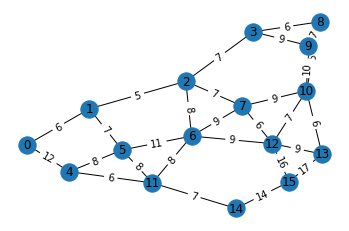

In [3]:
#creating the city 
g=nx.Graph()
nodes1=list(range(3))
labels=dict()
g.add_nodes_from(nodes1)
g.add_edge(0,1,weight=6)
g.add_edge(0,4,weight=12)
g.add_edge(1,2,weight=5)
g.add_edge(1,5,weight=7)
g.add_edge(2,3,weight=7)
g.add_edge(2,6,weight=8)
g.add_edge(2,7,weight=7)
g.add_edge(2,3,weight=7)
g.add_edge(3,8,weight=6)
g.add_edge(3,9,weight=9)
g.add_edge(4,5,weight=8)
g.add_edge(4,11,weight=6)
g.add_edge(5,6,weight=11)
g.add_edge(5,11,weight=8)
g.add_edge(6,7,weight=9)
g.add_edge(6,11,weight=8)
g.add_edge(6,12,weight=9)
g.add_edge(7,12,weight=6)
g.add_edge(7,10,weight=9)
g.add_edge(8,9,weight=7)
g.add_edge(8,10,weight=5)
g.add_edge(9,10,weight=10)
g.add_edge(10,12,weight=7)
g.add_edge(10,13,weight=6)
g.add_edge(11,14,weight=7)
g.add_edge(12,13,weight=9)
g.add_edge(12,15,weight=16)
g.add_edge(13,15,weight=17)
g.add_edge(14,15,weight=14)
pos=nx.spring_layout(g)
e_labels = nx.get_edge_attributes(g,'weight')
nx.draw_networkx_edge_labels(g,pos,edge_labels=e_labels)
nx.draw(g,pos,with_labels=True)

In [4]:
a=pos #figured out a preferred spring layout and saved it as a positioning dictionary 
a

{0: array([-1.       , -0.1611389]),
 1: array([-0.66277067,  0.09921882]),
 2: array([-0.14043692,  0.2994868 ]),
 4: array([-0.77200032, -0.35806271]),
 5: array([-0.48555012, -0.20017094]),
 3: array([0.22508786, 0.65941152]),
 6: array([-0.10906427, -0.09910314]),
 7: array([0.16643796, 0.11906625]),
 8: array([0.58712773, 0.73270954]),
 9: array([0.52314858, 0.55879013]),
 11: array([-0.32180903, -0.43979915]),
 12: array([ 0.32912166, -0.15418618]),
 10: array([0.51332598, 0.23125512]),
 13: array([ 0.59763396, -0.2298421 ]),
 14: array([ 0.13114609, -0.62555861]),
 15: array([ 0.41860151, -0.43207646])}

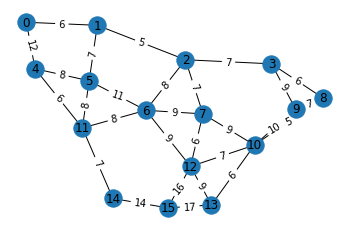

In [5]:
G=nx.Graph()
nodes1=list(range(3))
labels=dict()
G.add_nodes_from(nodes1)
G.add_edge(0,1,weight=6)
G.add_edge(0,4,weight=12)
G.add_edge(1,2,weight=5)
G.add_edge(1,5,weight=7)
G.add_edge(2,3,weight=7)
G.add_edge(2,6,weight=8)
G.add_edge(2,7,weight=7)
G.add_edge(2,3,weight=7)
G.add_edge(3,8,weight=6)
G.add_edge(3,9,weight=9)
G.add_edge(4,5,weight=8)
G.add_edge(4,11,weight=6)
G.add_edge(5,6,weight=11)
G.add_edge(5,11,weight=8)
G.add_edge(6,7,weight=9)
G.add_edge(6,11,weight=8)
G.add_edge(6,12,weight=9)
G.add_edge(7,12,weight=6)
G.add_edge(7,10,weight=9)
G.add_edge(8,9,weight=7)
G.add_edge(8,10,weight=5)
G.add_edge(9,10,weight=10)
G.add_edge(10,12,weight=7)
G.add_edge(10,13,weight=6)
G.add_edge(11,14,weight=7)
G.add_edge(12,13,weight=9)
G.add_edge(12,15,weight=16)
G.add_edge(13,15,weight=17)
G.add_edge(14,15,weight=14)
b={0: ([-0.91755185,  0.59751129]),
 1: ([-0.45894005,  0.57746404]),
 2: ([0.11162505, 0.34968724]),
 4: ([-0.86167858,  0.29025632]),
 5: ([-0.51175834,  0.21073095]),
 3: ([0.66812137, 0.32275414]),
 6: ([-0.1448217 ,  0.01564843]),
 7: ([ 0.2248257 , -0.00819707]),
 8: ([1.        , 0.09788319]),
 9: ([0.82388347, 0.02435849]),
 11: ([-0.55541787, -0.10125253]),
 12: ([ 0.1442438 , -0.35568988]),
 10: ([ 0.55839644, -0.21421801]),
 13: ([ 0.27971578, -0.60991997]),
 14: ([-0.35790646, -0.56743737]),
 15: ([-0.00273677, -0.62957926])}
names_list=['Marylebone','Fitzrovia','Bloomsbury','Clerkenwell','Mayfair',
            'Soho','Covent Garden','Holborn','Barbican','Spitalfields',
            'The City','St. James','South Bank','London Bridge','Westminster','Lambeth']
names_dict= { x: names_list[x] for x in range(0, len(names_list) ) }
nx.set_node_attributes(G,names_dict,name='Neighborhood')
e_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,b,edge_labels=e_labels)
nx.draw(G,b,with_labels=True)

In [6]:
list(G.nodes)

[0, 1, 2, 4, 5, 3, 6, 7, 8, 9, 11, 12, 10, 13, 14, 15]

In [7]:
def get_central(number,graph): 
    '''
    this function outputs a list with the x most central nodes of the network 
    according to closeness centrality measure
    '''
    centrality=nx.closeness_centrality(graph)
    most_central=sorted(centrality, key=centrality.get, reverse=True)[:number]
    return most_central

In [8]:
np.random.seed(121)
probs=[] #this list will contain the list of probabilities of neighborhoods for creating an emergency
for i in range(16):
    probs.append(np.random.random())

In [9]:
probs

[0.11133082800524441,
 0.2107675745428309,
 0.2329624876964297,
 0.15194455722114297,
 0.830178138297634,
 0.40791941490448025,
 0.5557905998327344,
 0.7455239422209097,
 0.24849975557759574,
 0.9686593992830126,
 0.9526841758665815,
 0.4898488501934425,
 0.018297308623126174,
 0.8576061165568013,
 0.4049382895898801,
 0.62247394127068]

In [10]:
def run_sim(days,stations,graph,probabilities):
    '''
    This fuction just runs the simulation above for the given 
    number of days and returns the data we want for our results such as:
    
    hist_times: list to create histogram for waiting times 
    hist_idle:list to create histogram for idle ambulances at a given time step 

    high_counters:list fot histogram for the number of emergencies 
    attended by the most active ambulance
    

    '''
    ambulances=150
    hist_times=[]
    hist_idle=[]
    central=get_central(stations,graph)
    high_counters=[]
    not_used=[]
    for i in range(days): # the number of days we will run the sim for 
        sim=EmergencyResponse(G,probabilities,ambulances,central)
        sim.create_paths()
        for x in range(1140):# a day's worth of ambulance
            sim.update()
            #if x%10==0:
                #print(sim.times_list)
                #print(sim.patient_list)
        sim.get_counters()
        hist_times.append(mean(sim.times_list))
        high_counters.append(sim.max_counter)
        not_used.append(sim.not_used)
        #low_counters.append(sim.min_counter)
        hist_idle.append(mean(sim.idle_list))
    #hist_times 
    return hist_times, hist_idle, high_counters, not_used

In [11]:
#FIRST STRATEGY  
#using the strategy of allocating the ambulances to the 3 most central nodes 

In [12]:
ambulances=150
hist_times3, hist_idle3, high_counters3, not_used3=run_sim(10000,3,G,probs)

Histograms for Stategy 1: Ambulances equally distributed in 3 stations


Text(0.5, 1.0, 'Average numbers of idle ambulances in a day')

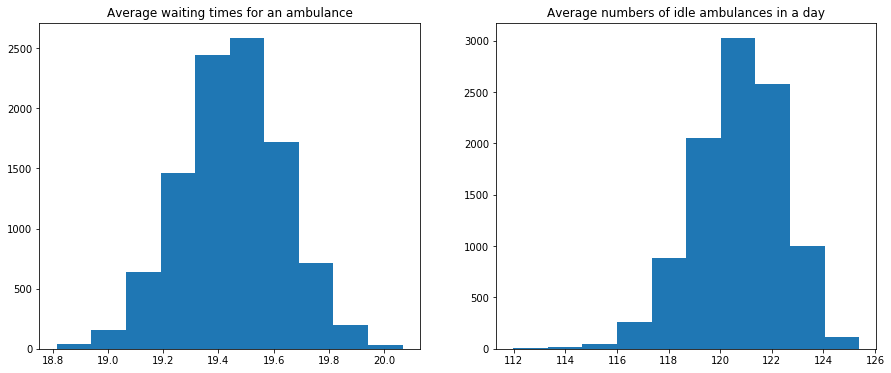

In [13]:
print('Histograms for Stategy 1: Ambulances equally distributed in 3 stations')
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.hist(hist_times3)
plt.title('Average waiting times for an ambulance')
plt.subplot(122)
plt.hist(hist_idle3)
plt.title('Average numbers of idle ambulances in a day')

Histograms for Stategy 1: Ambulances equally distributed in 3 stations


Text(0.5, 1.0, 'Total numbers of ambulances not called once in a day')

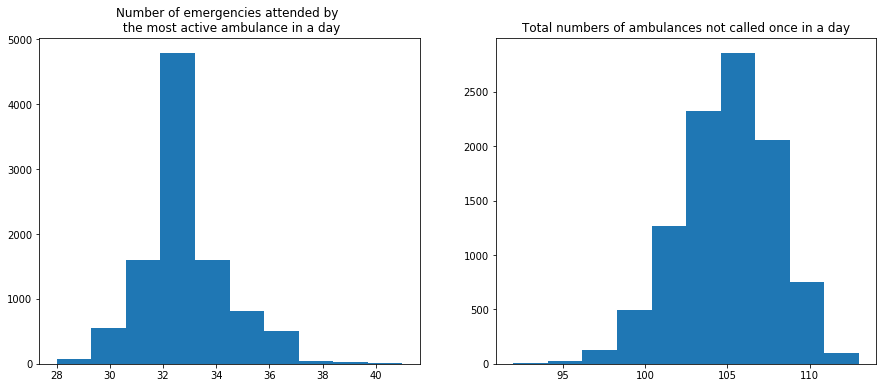

In [14]:
print('Histograms for Stategy 1: Ambulances equally distributed in 3 stations')
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.hist(high_counters3)
plt.title('Number of emergencies attended by \n the most active ambulance in a day')
plt.subplot(122)
plt.hist(not_used3)
plt.title('Total numbers of ambulances not called once in a day')

In [15]:
#confidence intervals 
def confidence(data,confidence):
    n=len(data)
    m=mean(data)
    standard_error=sem(data)
    r=standard_error*t.ppf((1+confidence)/2,n-1)
    bottom=m-r
    top=m+r
    return m,bottom,top

In [30]:
print('Strategy 1')
print('Confidence Interval for Average Waiting Times')
mean1,bottom1,top1=confidence(hist_times3,0.95)
print('Mean: %.2f' %(mean1))
print('Interval: (%.2f,%.2f)'%(bottom1,top1))
print('Confidence Interval for Idle Ambulances in a Day')
mean2,bottom2,top2=confidence(hist_idle3,0.95)
print('Mean: %.2f' %(mean2))
print('Interval: (%.2f,%.2f)'%(bottom2,top2))
print('Confidence Interval for emergencies attended by the most active ambulance')
mean3,bottom3,top3=confidence(high_counters3,0.95)
print('Mean: %.2f' %(mean3))
print('Interval: (%.2f,%.2f)'%(bottom3,top3))
print('Confidence Interval for number of unused ambulances')
mean4,bottom4,top4=confidence(not_used3,0.95)
print('Mean: %.2f' %(mean4))
print('Interval: (%.2f,%.2f)'%(bottom4,top4))

Strategy 1
Confidence Interval for Average Waiting Times
Mean: 19.45
Interval: (19.45,19.45)
Confidence Interval for Idle Ambulances in a Day
Mean: 120.70
Interval: (120.66,120.73)
Confidence Interval for emergencies attended by the most active ambulance
Mean: 32.77
Interval: (32.74,32.80)
Confidence Interval for number of unused ambulances
Mean: 104.86
Interval: (104.81,104.92)


In [17]:
#SECOND STRATEGY 
#using the strategy of allocating the ambulances to the 5 most central nodes 
hist_times5, hist_idle5, high_counters5, not_used5=run_sim(10000,5,G,probs)

Histograms for Stategy 2: Ambulances equally distributed in 5 stations


Text(0.5, 1.0, 'Average numbers of idle ambulances in a day')

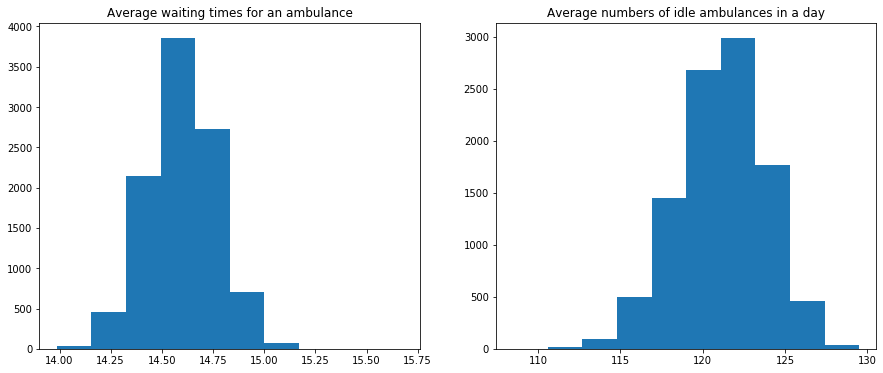

In [18]:
print('Histograms for Stategy 2: Ambulances equally distributed in 5 stations')
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.hist(hist_times5)
plt.title('Average waiting times for an ambulance')
plt.subplot(122)
plt.hist(hist_idle5)
plt.title('Average numbers of idle ambulances in a day')

Histograms for Stategy 2: Ambulances equally distributed in 5 stations


Text(0.5, 1.0, 'Total numbers of ambulances not called once in a day')

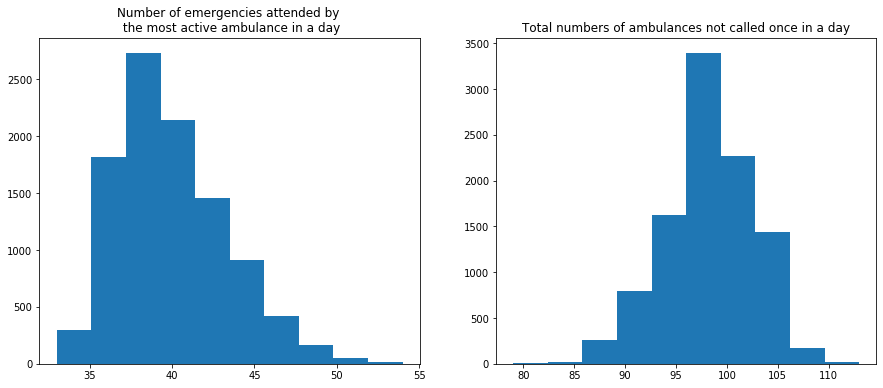

In [19]:
print('Histograms for Stategy 2: Ambulances equally distributed in 5 stations')
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.hist(high_counters5)
plt.title('Number of emergencies attended by \n the most active ambulance in a day')
plt.subplot(122)
plt.hist(not_used5)
plt.title('Total numbers of ambulances not called once in a day')

In [20]:
print('Strategy 2')
print('Confidence Interval for Average Waiting Times')
mean1,bottom1,top1=confidence(hist_times5,0.95)
print('Mean: %.2f' %(mean1))
print('Interval: (%.2f,%.2f)'%(bottom1,top1))
print('Confidence Interval for Idle Ambulances in a Day')
mean2,bottom2,top2=confidence(hist_idle5,0.95)
print('Mean: %.2f' %(mean2))
print('Interval: (%.2f,%.2f)'%(bottom2,top2))
print('Confidence Interval for emergencies attended by the most active ambulance')
mean3,bottom3,top3=confidence(high_counters5,0.95)
print('Mean: %.2f' %(mean3))
print('Interval: (%.2f,%.2f)'%(bottom3,top3))
print('Confidence Interval for number of unused ambulances')
mean4,bottom4,top4=confidence(not_used5,0.95)
print('Mean: %.2f' %(mean4))
print('Interval: (%.2f,%.2f)'%(bottom4,top4))

Strategy 2
Confidence Interval for Average Waiting Times
Mean: 14.60
Interval: (14.59,14.60)
Confidence Interval for Idle Ambulances in a Day
Mean: 121.15
Interval: (121.09,121.20)
Confidence Interval for emergencies attended by the most active ambulance
Mean: 40.16
Interval: (40.10,40.22)
Confidence Interval for number of unused ambulances
Mean: 98.11
Interval: (98.03,98.20)


In [21]:
#THIRD STRATEGY 
#using the strategy of allocating the ambulances to the 8 most central nodes 
hist_times8, hist_idle8, high_counters8, not_used8=run_sim(10000,8,G,probs)

Histograms for Stategy 3: Ambulances equally distributed in 8 stations


Text(0.5, 1.0, 'Average numbers of idle ambulances in a day')

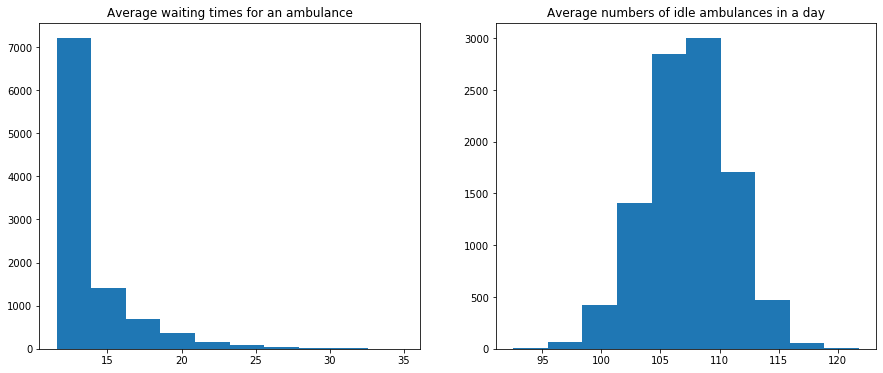

In [22]:
print('Histograms for Stategy 3: Ambulances equally distributed in 8 stations')
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.hist(hist_times8)
plt.title('Average waiting times for an ambulance')
plt.subplot(122)
plt.hist(hist_idle8)
plt.title('Average numbers of idle ambulances in a day')

Histograms for Stategy 3: Ambulances equally distributed in 8 stations


Text(0.5, 1.0, 'Total numbers of ambulances not called once in a day')

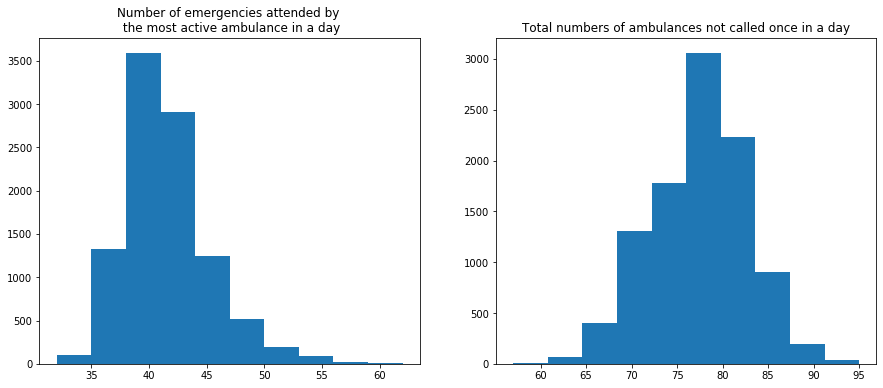

In [23]:
print('Histograms for Stategy 3: Ambulances equally distributed in 8 stations')
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.hist(high_counters8)
plt.title('Number of emergencies attended by \n the most active ambulance in a day')
plt.subplot(122)
plt.hist(not_used8)
plt.title('Total numbers of ambulances not called once in a day')

In [29]:
print('Strategy 3')
print('Confidence Interval for Average Waiting Times')
mean1,bottom1,top1=confidence(hist_times8,0.95)
print('Mean: %.2f' %(mean1))
print('Interval: (%.2f,%.2f)'%(bottom1,top1))
print('Confidence Interval for Idle Ambulances in a Day')
mean2,bottom2,top2=confidence(hist_idle8,0.95)
print('Mean: %.2f' %(mean2))
print('Interval: (%.2f,%.2f)'%(bottom2,top2))
print('Confidence Interval for emergencies attended by the most active ambulance')
mean3,bottom3,top3=confidence(high_counters8,0.95)
print('Mean: %.2f' %(mean3))
print('Interval: (%.2f,%.2f)'%(bottom3,top3))
print('Confidence Interval for number of unused ambulances')
mean4,bottom4,top4=confidence(not_used8,0.95)
print('Mean: %.2f' %(mean4))
print('Interval: (%.2f,%.2f)'%(bottom4,top4))

Strategy 3
Confidence Interval for Average Waiting Times
Mean: 13.81
Interval: (13.76,13.87)
Confidence Interval for Idle Ambulances in a Day
Mean: 107.33
Interval: (107.26,107.40)
Confidence Interval for emergencies attended by the most active ambulance
Mean: 41.07
Interval: (40.99,41.14)
Confidence Interval for number of unused ambulances
Mean: 77.30
Interval: (77.20,77.41)


In [25]:
#FOURTH STRATEGY 
#using the strategy of allocating the ambulances to the 10 most central nodes 
hist_times10, hist_idle10, high_counters10, not_used10=run_sim(10000,10,G,probs)

Histograms for Stategy 4: Ambulances equally distributed in 10 stations


Text(0.5, 1.0, 'Average numbers of idle ambulances in a day')

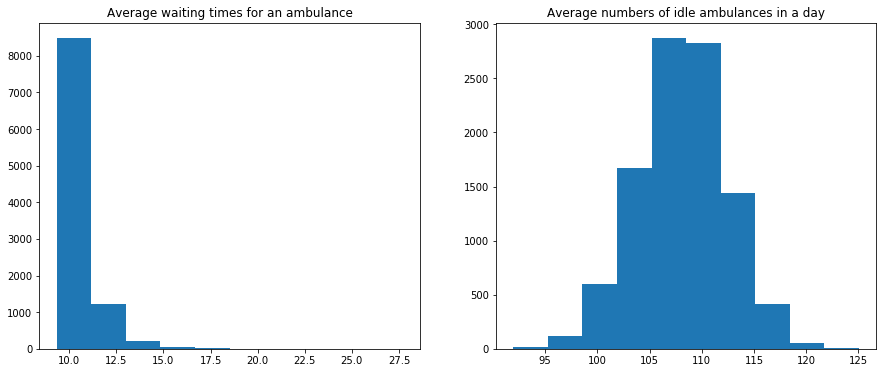

In [26]:
print('Histograms for Stategy 4: Ambulances equally distributed in 10 stations')
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.hist(hist_times10)
plt.title('Average waiting times for an ambulance')
plt.subplot(122)
plt.hist(hist_idle10)
plt.title('Average numbers of idle ambulances in a day')

Histograms for Stategy 4: Ambulances equally distributed in 10 stations


Text(0.5, 1.0, 'Total numbers of ambulances not called once in a day')

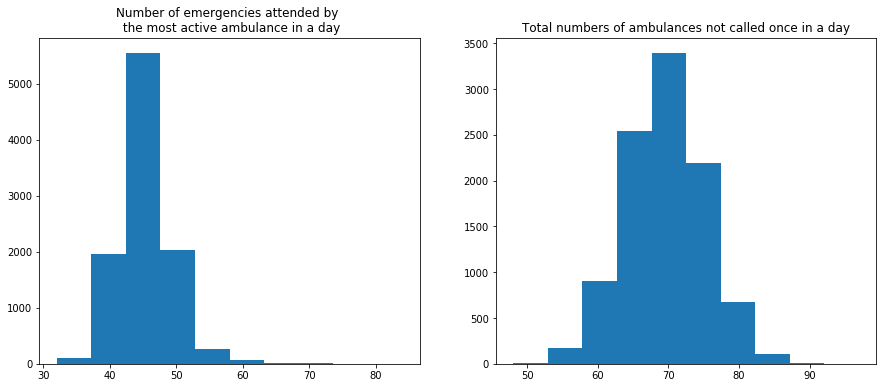

In [31]:
print('Histograms for Stategy 4: Ambulances equally distributed in 10 stations')
plt.figure(figsize=(15,6))
plt.subplot(121)
plt.hist(high_counters10)
plt.title('Number of emergencies attended by \n the most active ambulance in a day')
plt.subplot(122)
plt.hist(not_used10)
plt.title('Total numbers of ambulances not called once in a day')

In [28]:
print('Strategy 4')
print('Confidence Interval for Average Waiting Times')
mean1,bottom1,top1=confidence(hist_times10,0.95)
print('Mean: %.2f' %(mean1))
print('Interval: (%.2f,%.2f)'%(bottom1,top1))
print('Confidence Interval for Idle Ambulances in a Day')
mean2,bottom2,top2=confidence(hist_idle10,0.95)
print('Mean: %.2f' %(mean2))
print('Interval: (%.2f,%.2f)'%(bottom2,top2))
print('Confidence Interval for emergencies attended by the most active ambulance')
mean3,bottom3,top3=confidence(high_counters10,0.95)
print('Mean: %.2f' %(mean3))
print('Interval: (%.2f,%.2f)'%(bottom3,top3))
print('Confidence Interval for number of unused ambulances')
mean4,bottom4,top4=confidence(not_used10,0.95)
print('Mean: %.2f' %(mean4))
print('Interval: (%.2f,%.2f)'%(bottom4,top4))

Strategy 4
Confidence Interval for Average Waiting Times
Mean: 10.49
Interval: (10.47,10.51)
Confidence Interval for Idle Ambulances in a Day
Mean: 108.13
Interval: (108.05,108.21)
Confidence Interval for emergencies attended by the most active ambulance
Mean: 45.38
Interval: (45.30,45.45)
Confidence Interval for number of unused ambulances
Mean: 69.47
Interval: (69.36,69.58)
